# Chapter3 - Calsification 

### MNIST Dataset - Handwritten digits

In [24]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [2]:
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

#### Open ML
Opne ML provides access to popular datasets.<br/>
These datasets generally have a similar structure:

In [3]:
#Description of the DS
mnist["DESCR"]

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
# Array with one row per instance and one column per feature
mnist["data"]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
# Array of labels
mnist["target"]

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
x, y = mnist["data"], mnist["target"]
print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


In [7]:
some_digit = x[0]
some_digit_image = some_digit.reshape(28,28)

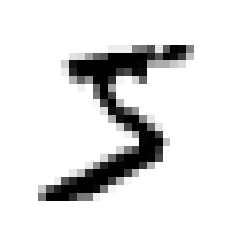

In [8]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

Note that 'y' is a STRING. Most ML algorithms expect numbers. Let's cast y to INTEGER.

In [10]:
y = y.astype(np.uint8)
y[0]

5

First things first, we should separate a training set. Thankfully this DS is already split into a 10000 image test set and 60000 train set. 

In [11]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

## Binary Classifier - 5-detector
Binary Classifier to distinguish 5 from other numbers.

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### Stochastic Gradient Descent Classifier
Good with large DS because it deals with each instance individually. Good with online learning.<br/>
SGDClassifier relies on randomness, hence the name stochastic. Use a seed (random_state) to deproduce the result.

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
#Let's try with some_digit which was a 5:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures
### Measuring accuracy with corss-validation for classifiers

When you need more control over the cross-validation process, you can implement your own custom cross-validation.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

#Nº of interations = n_splits
for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    #We first train the model with the train fold separated by the
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


Let's use cross_validation_score() to check the accuracy of our SGDClasification Model

In [16]:
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

96% accuracy! If we have 10 digits and the model returns false (as if the number is not 5) to all of the numbers, it would have ~90% accuracy

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [18]:
test_clf = Never5Classifier()
test_clf.fit(x_train, y_train_5)
test_pred = test_clf.predict(x_train) 
test_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [19]:
cross_val_score(test_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix
A better way to evaluate the performance of a classifier is to use a Confusion Matrix. The idea is to count how many times the model confused a given number with another number. <br/>

Structure:<br/>
- Rows: Real class
- Columns: Predictied class

A confusion matrix compares the prediction of a model with the labels of the model. If we used the training model to make the predictions, the result of the confusion matrix couldn't be trusted. If we used the test set that we separated at the beginnig of the exercise, we would loose our only test set. To make sure that the predictions are maded with a set that wasn't involved in the training of the model, we can use cross_validation_predict()

In [20]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

# 0x0 = Real = False, Pred = False - 0x1 = Real = False, Pred = True
# 1x0 = Real = True, Pred = False  - 1x1 = Real = True, Pred = True
# 0x0 -> True Negative 
# 1x1 -> True Positive
#
# confusion_matrix(y_true, y_predicted)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

##### Precision - ????
When you can't afford a false positive.

TP/(TP + FP)

In [22]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

##### Recall - Sensibilidad
When you cant addord a false negative.

TP/(TP + FN)

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### F1 Score
Harmonic mean of precision and recall. It gives more weight to the low values.

In [25]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846